# Signals and Systems for Dummies, Chapter 15

In [1]:
from pathlib import Path
import sys

if (root := str(Path().resolve().parent.parent / "python")) not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

import numpy as np
from scipy import signal, fft
import matplotlib.pyplot as plt
from matplotlib import rcParams
import math
from rfdsppy import continuous_time as conttime, plotting, discrete_time, tonegen
# import mplcursors

from importlib import reload

reload(conttime)
reload(plotting)
reload(discrete_time)
reload(tonegen)

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


## Frequency response

Text(0.5, 0.98, 'Butterworth Filter, Order=3\nDroop=2.993, Atten=59.981')

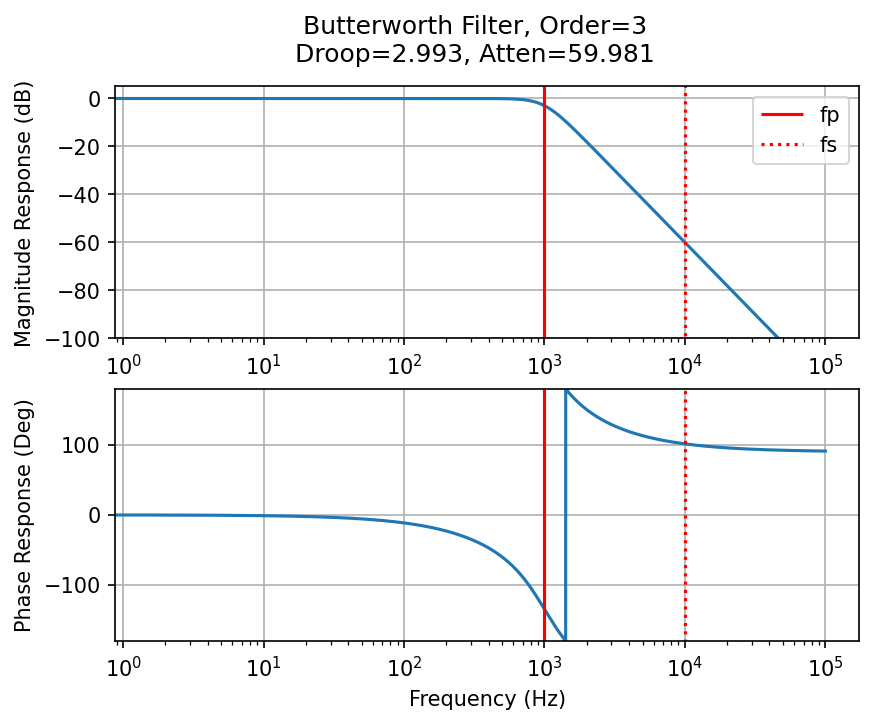

In [ ]:
wp = 2*np.pi*1000 # passband cutoff
ws = 2*np.pi*10000 # stopband cutoff
gpass = 3 # max passband droop (dB)
gstop = 50 # min stopband attenuation (dB)

ord, wn = signal.buttord(wp, ws, gpass, gstop, analog=True)

# print(ord)
# print(wn)

bk, ak = signal.butter(ord, wn, analog=True)

# print(bk)
# print(ak)

w, h = signal.freqs(bk, ak, worN=np.linspace(0, 2*np.pi*100000, 2**16))
droop = -20*np.log10(np.abs(h[w <= wp]).min())
atten = -20*np.log10(np.abs(h[w >= ws]).max())

fig, axs = plt.subplots(nrows=2, sharex=True, dpi=150)

axs[0].semilogx(w/2/np.pi, 20*np.log10(np.abs(h)))
axs[0].set_ylabel("Magnitude Response (dB)")
axs[0].tick_params(labelbottom=True)
# axs[0].vlines([1000, 10000], color='r', ymin=-1000, ymax=1000)
axs[0].vlines([1000], color='r', ymin=-1000, ymax=1000, label="fp")
axs[0].vlines([10000], color='r', linestyles='dotted', ymin=-1000, ymax=1000, label="fs")
axs[0].legend()
axs[0].set_ylim(bottom=-100, top=5)
axs[0].grid()
axs[1].semilogx(w/2/np.pi, np.angle(h)*180/np.pi)
axs[1].vlines([1000], color='r', ymin=-1000, ymax=1000, label="fp")
axs[1].vlines([10000], color='r', linestyles='dotted', ymin=-1000, ymax=1000, label="fs")
axs[1].set_ylabel("Phase Response (Deg)")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylim(bottom=-180, top=180)
axs[1].grid()
# axs[0].set_title(f"Butterworth Filter, Order={ord}")
fig.suptitle(f"Butterworth Filter, Order={ord}\nDroop={np.round(droop,3)}, Atten={np.round(atten,3)}")

## Step response using signal.step

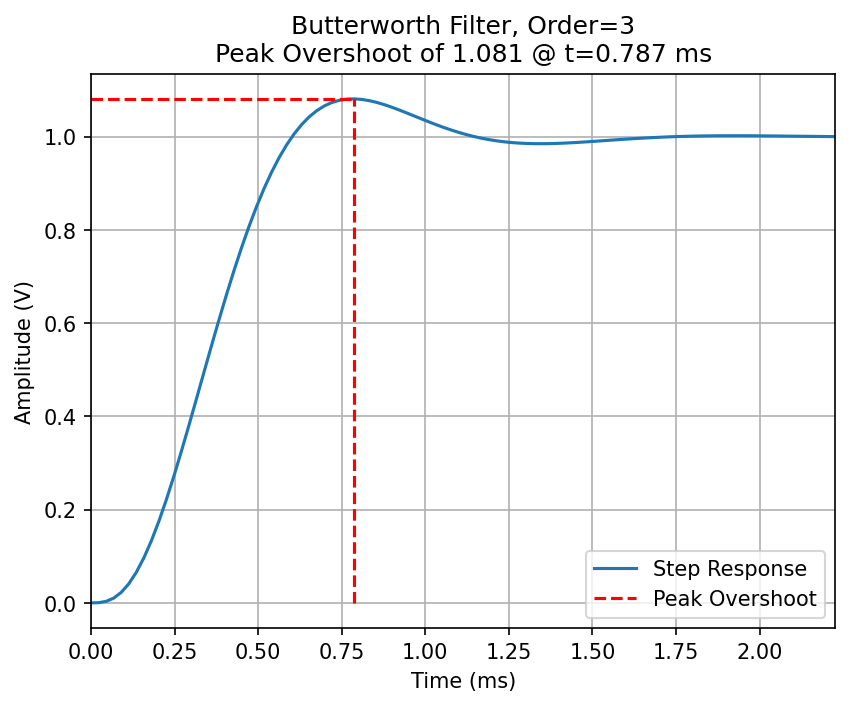

In [71]:
lti = signal.lti(bk, ak)
t, y = signal.step(lti)
idx_max = y.argmax()
t_overshoot = t[idx_max]
y_overshoot = y[idx_max]

fig, axs = plt.subplots(dpi=150)
axs.plot(t*1000, y, label="Step Response")
axs.vlines([t_overshoot*1000], ymin=0, ymax=y_overshoot, color='r', linestyles='dashed', label="Peak Overshoot")
axs.hlines([y_overshoot], xmin=0, xmax=t_overshoot*1000, color='r', linestyles='dashed')
axs.set_xlabel("Time (ms)")
axs.set_ylabel("Amplitude (V)")
axs.set_xlim(left=t[0]*1000, right=t[-1]*1000)
axs.set_title(f"""Butterworth Filter, Order={ord}
Peak Overshoot of {np.round(y_overshoot,3)} @ t={np.round(1000*t_overshoot,3)} ms""")
axs.legend()
axs.grid()

## Step response using signal.lsim

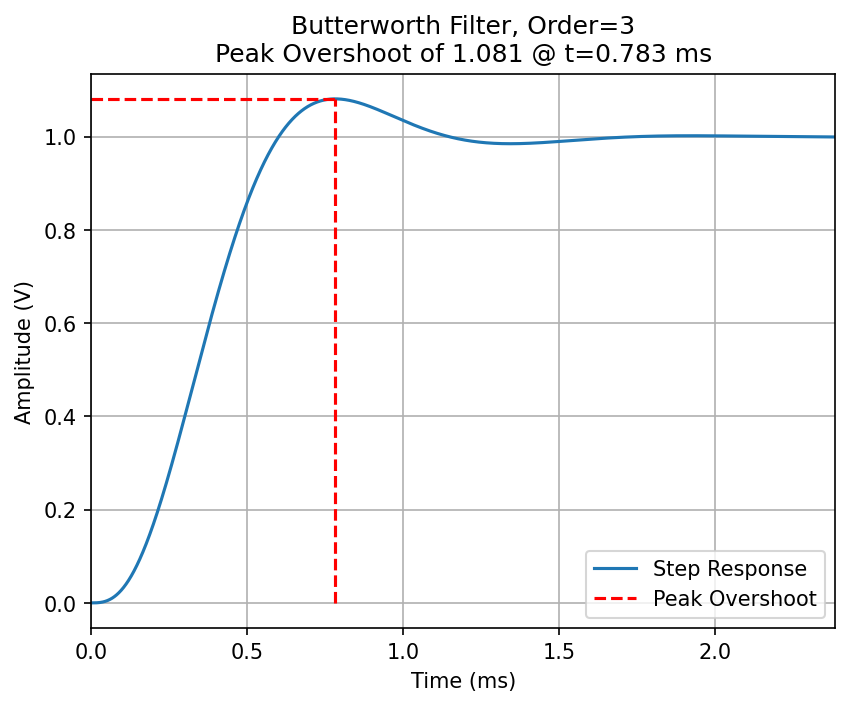

In [72]:
lti = signal.lti(bk, ak)
t = np.linspace(0, 15/wn, 2**12)
x = np.ones_like(t, dtype="float")
_, y, _ = signal.lsim(lti, x, t)
idx_max = y.argmax()
t_overshoot = t[idx_max]
y_overshoot = y[idx_max]

fig, axs = plt.subplots(dpi=150)
axs.plot(t*1000, y, label="Step Response")
axs.vlines([t_overshoot*1000], ymin=0, ymax=y_overshoot, color='r', linestyles='dashed', label="Peak Overshoot")
axs.hlines([y_overshoot], xmin=0, xmax=t_overshoot*1000, color='r', linestyles='dashed')
axs.set_xlabel("Time (ms)")
axs.set_ylabel("Amplitude (V)")
axs.set_xlim(left=t[0]*1000, right=t[-1]*1000)
axs.set_title(f"""Butterworth Filter, Order={ord}
Peak Overshoot of {np.round(y_overshoot,3)} @ t={np.round(1000*t_overshoot,3)} ms""")
axs.legend()
axs.grid()

## Step response using inverse LT

The s domain representation of the step response is equal to X(s)/s.

Multiply the denominator of X(s) by s. This is equivalent to multiplying by the first-order polynomial s + 0. When you multiply two polynomials, the coefficient arrays for each polynomial are convolved, as in sequence convolution.

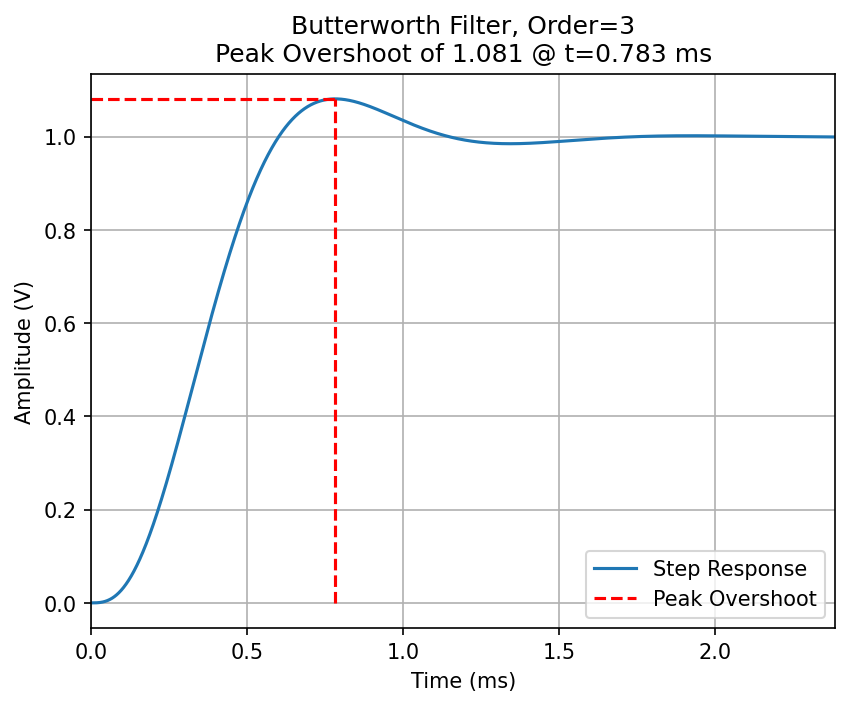

In [73]:
# Multiply denominator by s + 0
ak_out = signal.convolve(ak, [1, 0])

r, p, k = signal.residue(bk, ak_out)
# print(r)
# print(p)
# print(k)

t = np.linspace(0, 15/wn, 2**12)
# y = r[0]*np.exp(p[0]*t) + r[1]*np.exp(p[1]*t) + \
# r[2]*np.exp(p[2]*t) + r[3]*np.exp(p[3]*t)

y = np.zeros_like(t, dtype='float')
for i in range(len(r)):
    y = y + r[i]*np.exp(p[i]*t)
y = y.real

idx_max = y.argmax()
t_overshoot = t[idx_max]
y_overshoot = y[idx_max]

fig, axs = plt.subplots(dpi=150)
axs.plot(t*1000, y, label="Step Response")
axs.vlines([t_overshoot*1000], ymin=0, ymax=y_overshoot, color='r', linestyles='dashed', label="Peak Overshoot")
axs.hlines([y_overshoot], xmin=0, xmax=t_overshoot*1000, color='r', linestyles='dashed')
axs.set_xlabel("Time (ms)")
axs.set_ylabel("Amplitude (V)")
axs.set_xlim(left=t[0]*1000, right=t[-1]*1000)
axs.set_title(f"""Butterworth Filter, Order={ord}
Peak Overshoot of {np.round(y_overshoot,3)} @ t={np.round(1000*t_overshoot,3)} ms""")
axs.legend()
axs.grid()